<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:46:01] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


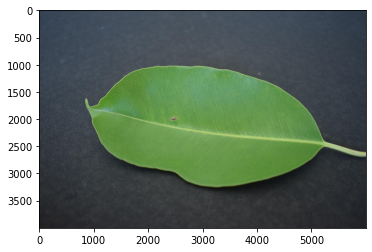

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

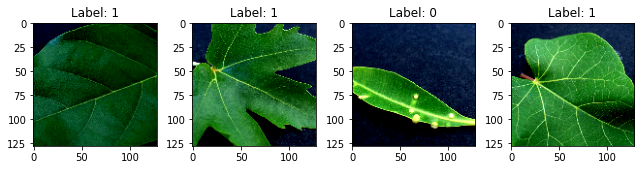

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

[21:46:09] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:46:11] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2541298404232457 samples/sec                   batch loss = 0.838397204875946 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2577898449677958 samples/sec                   batch loss = 0.5366458892822266 | accuracy = 0.45


Epoch[1] Batch[15] Speed: 1.256044199728895 samples/sec                   batch loss = 1.1720178127288818 | accuracy = 0.5333333333333333


Epoch[1] Batch[20] Speed: 1.2605210301893792 samples/sec                   batch loss = 0.34191572666168213 | accuracy = 0.5125


Epoch[1] Batch[25] Speed: 1.2328584399562976 samples/sec                   batch loss = 1.2855408191680908 | accuracy = 0.53


Epoch[1] Batch[30] Speed: 1.2580003503190063 samples/sec                   batch loss = 0.6717058420181274 | accuracy = 0.5583333333333333


Epoch[1] Batch[35] Speed: 1.2526288478718015 samples/sec                   batch loss = 1.5341795682907104 | accuracy = 0.5642857142857143


Epoch[1] Batch[40] Speed: 1.2601243343723199 samples/sec                   batch loss = 0.8526486754417419 | accuracy = 0.56875


Epoch[1] Batch[45] Speed: 1.264105802266621 samples/sec                   batch loss = 0.3835003972053528 | accuracy = 0.5888888888888889


Epoch[1] Batch[50] Speed: 1.2644080902385515 samples/sec                   batch loss = 0.5049245357513428 | accuracy = 0.59


Epoch[1] Batch[55] Speed: 1.2656966009577135 samples/sec                   batch loss = 0.504368782043457 | accuracy = 0.5772727272727273


Epoch[1] Batch[60] Speed: 1.2657141706106718 samples/sec                   batch loss = 0.2956869900226593 | accuracy = 0.575


Epoch[1] Batch[65] Speed: 1.2657945770940984 samples/sec                   batch loss = 0.7675768733024597 | accuracy = 0.5846153846153846


Epoch[1] Batch[70] Speed: 1.2684082781078438 samples/sec                   batch loss = 0.7968363165855408 | accuracy = 0.5892857142857143


Epoch[1] Batch[75] Speed: 1.250226613231351 samples/sec                   batch loss = 0.29506605863571167 | accuracy = 0.5966666666666667


Epoch[1] Batch[80] Speed: 1.2439722398382005 samples/sec                   batch loss = 0.2776812016963959 | accuracy = 0.60625


Epoch[1] Batch[85] Speed: 1.2564150895778652 samples/sec                   batch loss = 0.44757306575775146 | accuracy = 0.611764705882353


Epoch[1] Batch[90] Speed: 1.2624940110002696 samples/sec                   batch loss = 0.5878849029541016 | accuracy = 0.6111111111111112


Epoch[1] Batch[95] Speed: 1.2623782125821452 samples/sec                   batch loss = 0.7233095169067383 | accuracy = 0.6105263157894737


Epoch[1] Batch[100] Speed: 1.2673421457185243 samples/sec                   batch loss = 0.4728623628616333 | accuracy = 0.6075


Epoch[1] Batch[105] Speed: 1.2671512801446816 samples/sec                   batch loss = 0.6376246213912964 | accuracy = 0.611904761904762


Epoch[1] Batch[110] Speed: 1.2626937395596922 samples/sec                   batch loss = 1.191135287284851 | accuracy = 0.6090909090909091


Epoch[1] Batch[115] Speed: 1.2663785466747743 samples/sec                   batch loss = 0.5345577001571655 | accuracy = 0.6065217391304348


Epoch[1] Batch[120] Speed: 1.2627746181429857 samples/sec                   batch loss = 0.5687909126281738 | accuracy = 0.6041666666666666


Epoch[1] Batch[125] Speed: 1.2629990605732633 samples/sec                   batch loss = 0.6415721774101257 | accuracy = 0.608


Epoch[1] Batch[130] Speed: 1.2609376875420555 samples/sec                   batch loss = 0.3911355137825012 | accuracy = 0.6096153846153847


Epoch[1] Batch[135] Speed: 1.2710432913574488 samples/sec                   batch loss = 0.975255012512207 | accuracy = 0.6037037037037037


Epoch[1] Batch[140] Speed: 1.2583871205582646 samples/sec                   batch loss = 0.6517369747161865 | accuracy = 0.6035714285714285


Epoch[1] Batch[145] Speed: 1.2615524708311574 samples/sec                   batch loss = 0.3445335626602173 | accuracy = 0.6051724137931035


Epoch[1] Batch[150] Speed: 1.265291392999485 samples/sec                   batch loss = 0.5914779305458069 | accuracy = 0.6066666666666667


Epoch[1] Batch[155] Speed: 1.2613977704290125 samples/sec                   batch loss = 0.3263494372367859 | accuracy = 0.6112903225806452


Epoch[1] Batch[160] Speed: 1.2558219401102582 samples/sec                   batch loss = 0.6040324568748474 | accuracy = 0.615625


Epoch[1] Batch[165] Speed: 1.2605914011296413 samples/sec                   batch loss = 0.4808790385723114 | accuracy = 0.6151515151515151


Epoch[1] Batch[170] Speed: 1.2646699104777197 samples/sec                   batch loss = 0.8291814923286438 | accuracy = 0.6161764705882353


Epoch[1] Batch[175] Speed: 1.2613788030340667 samples/sec                   batch loss = 0.8125646114349365 | accuracy = 0.62


Epoch[1] Batch[180] Speed: 1.262867769653837 samples/sec                   batch loss = 0.6310004591941833 | accuracy = 0.6222222222222222


Epoch[1] Batch[185] Speed: 1.2681300504025508 samples/sec                   batch loss = 0.25350531935691833 | accuracy = 0.6216216216216216


Epoch[1] Batch[190] Speed: 1.264835999014199 samples/sec                   batch loss = 0.45511889457702637 | accuracy = 0.6223684210526316


Epoch[1] Batch[195] Speed: 1.2698212403534714 samples/sec                   batch loss = 1.234057068824768 | accuracy = 0.6230769230769231


Epoch[1] Batch[200] Speed: 1.2654460954962405 samples/sec                   batch loss = 0.3714241087436676 | accuracy = 0.625


Epoch[1] Batch[205] Speed: 1.2674986907391363 samples/sec                   batch loss = 0.48374149203300476 | accuracy = 0.6304878048780488


Epoch[1] Batch[210] Speed: 1.2422023504324922 samples/sec                   batch loss = 0.21988289058208466 | accuracy = 0.6333333333333333


Epoch[1] Batch[215] Speed: 1.2529156593323092 samples/sec                   batch loss = 1.495585322380066 | accuracy = 0.6313953488372093


Epoch[1] Batch[220] Speed: 1.2635335374702874 samples/sec                   batch loss = 0.44523561000823975 | accuracy = 0.634090909090909


Epoch[1] Batch[225] Speed: 1.263560658603591 samples/sec                   batch loss = 0.5319719910621643 | accuracy = 0.6366666666666667


Epoch[1] Batch[230] Speed: 1.2590810530215868 samples/sec                   batch loss = 0.6089774370193481 | accuracy = 0.6402173913043478


Epoch[1] Batch[235] Speed: 1.2671690816235357 samples/sec                   batch loss = 0.4409846067428589 | accuracy = 0.6425531914893617


Epoch[1] Batch[240] Speed: 1.2599844616183573 samples/sec                   batch loss = 0.4469861686229706 | accuracy = 0.6427083333333333


Epoch[1] Batch[245] Speed: 1.262701817448347 samples/sec                   batch loss = 0.49690738320350647 | accuracy = 0.6418367346938776


Epoch[1] Batch[250] Speed: 1.2630388049880996 samples/sec                   batch loss = 0.8533974885940552 | accuracy = 0.644


Epoch[1] Batch[255] Speed: 1.2635660829699664 samples/sec                   batch loss = 0.3295556902885437 | accuracy = 0.6470588235294118


Epoch[1] Batch[260] Speed: 1.2621760200176118 samples/sec                   batch loss = 0.4542240798473358 | accuracy = 0.6490384615384616


Epoch[1] Batch[265] Speed: 1.2598632573725494 samples/sec                   batch loss = 0.6680145859718323 | accuracy = 0.6462264150943396


Epoch[1] Batch[270] Speed: 1.2625804699369816 samples/sec                   batch loss = 0.5864278078079224 | accuracy = 0.6509259259259259


Epoch[1] Batch[275] Speed: 1.263761010405236 samples/sec                   batch loss = 0.3393571674823761 | accuracy = 0.6536363636363637


Epoch[1] Batch[280] Speed: 1.2631951446105283 samples/sec                   batch loss = 0.5404127240180969 | accuracy = 0.6535714285714286


Epoch[1] Batch[285] Speed: 1.2664374321384877 samples/sec                   batch loss = 0.4402170479297638 | accuracy = 0.656140350877193


Epoch[1] Batch[290] Speed: 1.2567999440264155 samples/sec                   batch loss = 0.6014018058776855 | accuracy = 0.6543103448275862


Epoch[1] Batch[295] Speed: 1.2558282382634118 samples/sec                   batch loss = 0.5313549637794495 | accuracy = 0.6550847457627119


Epoch[1] Batch[300] Speed: 1.2494670265450794 samples/sec                   batch loss = 0.8702443242073059 | accuracy = 0.6566666666666666


Epoch[1] Batch[305] Speed: 1.2543104263576295 samples/sec                   batch loss = 0.7891830801963806 | accuracy = 0.6581967213114754


Epoch[1] Batch[310] Speed: 1.2599746205912064 samples/sec                   batch loss = 0.89970463514328 | accuracy = 0.660483870967742


Epoch[1] Batch[315] Speed: 1.2588606456130431 samples/sec                   batch loss = 0.5626588463783264 | accuracy = 0.6595238095238095


Epoch[1] Batch[320] Speed: 1.2511720311427974 samples/sec                   batch loss = 0.5314846038818359 | accuracy = 0.65859375


Epoch[1] Batch[325] Speed: 1.2612823626550955 samples/sec                   batch loss = 0.31430506706237793 | accuracy = 0.6615384615384615


Epoch[1] Batch[330] Speed: 1.2604858950161073 samples/sec                   batch loss = 0.5246063470840454 | accuracy = 0.6590909090909091


Epoch[1] Batch[335] Speed: 1.2561521612921436 samples/sec                   batch loss = 0.835814893245697 | accuracy = 0.6567164179104478


Epoch[1] Batch[340] Speed: 1.2404506052377586 samples/sec                   batch loss = 0.5066176056861877 | accuracy = 0.6573529411764706


Epoch[1] Batch[345] Speed: 1.2476767460426355 samples/sec                   batch loss = 0.5360841751098633 | accuracy = 0.6565217391304348


Epoch[1] Batch[350] Speed: 1.2597258072424329 samples/sec                   batch loss = 0.6845282912254333 | accuracy = 0.6571428571428571


Epoch[1] Batch[355] Speed: 1.2605090025645622 samples/sec                   batch loss = 0.11869917809963226 | accuracy = 0.6584507042253521


Epoch[1] Batch[360] Speed: 1.2560342320883604 samples/sec                   batch loss = 0.459208607673645 | accuracy = 0.6590277777777778


Epoch[1] Batch[365] Speed: 1.2578550073298331 samples/sec                   batch loss = 0.4679427742958069 | accuracy = 0.660958904109589


Epoch[1] Batch[370] Speed: 1.259770264773614 samples/sec                   batch loss = 0.4356077015399933 | accuracy = 0.6621621621621622


Epoch[1] Batch[375] Speed: 1.2575061703355137 samples/sec                   batch loss = 0.22733688354492188 | accuracy = 0.6633333333333333


Epoch[1] Batch[380] Speed: 1.2600582742223125 samples/sec                   batch loss = 0.9717079997062683 | accuracy = 0.6631578947368421


Epoch[1] Batch[385] Speed: 1.254514421608028 samples/sec                   batch loss = 1.1001100540161133 | accuracy = 0.6623376623376623


Epoch[1] Batch[390] Speed: 1.2578289792958333 samples/sec                   batch loss = 0.6966552734375 | accuracy = 0.6602564102564102


Epoch[1] Batch[395] Speed: 1.2607322613226795 samples/sec                   batch loss = 0.3823282718658447 | accuracy = 0.660759493670886


Epoch[1] Batch[400] Speed: 1.260492429441845 samples/sec                   batch loss = 0.26451435685157776 | accuracy = 0.661875


Epoch[1] Batch[405] Speed: 1.2626457495286871 samples/sec                   batch loss = 1.0039442777633667 | accuracy = 0.662962962962963


Epoch[1] Batch[410] Speed: 1.2650577408442276 samples/sec                   batch loss = 0.7914944887161255 | accuracy = 0.6634146341463415


Epoch[1] Batch[415] Speed: 1.259890505007056 samples/sec                   batch loss = 0.19761203229427338 | accuracy = 0.6650602409638554


Epoch[1] Batch[420] Speed: 1.2633182274737191 samples/sec                   batch loss = 0.5877193212509155 | accuracy = 0.6672619047619047


Epoch[1] Batch[425] Speed: 1.2579751651891253 samples/sec                   batch loss = 0.4254877269268036 | accuracy = 0.6676470588235294


Epoch[1] Batch[430] Speed: 1.2673771854647449 samples/sec                   batch loss = 0.8606585264205933 | accuracy = 0.6680232558139535


Epoch[1] Batch[435] Speed: 1.2602812786601 samples/sec                   batch loss = 0.28880995512008667 | accuracy = 0.667816091954023


Epoch[1] Batch[440] Speed: 1.256974707540058 samples/sec                   batch loss = 0.2171240746974945 | accuracy = 0.66875


Epoch[1] Batch[445] Speed: 1.2574995725815705 samples/sec                   batch loss = 0.8185221552848816 | accuracy = 0.6707865168539325


Epoch[1] Batch[450] Speed: 1.2594414478743436 samples/sec                   batch loss = 0.707723081111908 | accuracy = 0.67


Epoch[1] Batch[455] Speed: 1.256677092525433 samples/sec                   batch loss = 0.30588579177856445 | accuracy = 0.6708791208791208


Epoch[1] Batch[460] Speed: 1.2572528662890536 samples/sec                   batch loss = 0.913884162902832 | accuracy = 0.6701086956521739


Epoch[1] Batch[465] Speed: 1.2657712753516908 samples/sec                   batch loss = 0.8387779593467712 | accuracy = 0.6709677419354839


Epoch[1] Batch[470] Speed: 1.265853408260951 samples/sec                   batch loss = 0.36619552969932556 | accuracy = 0.6728723404255319


Epoch[1] Batch[475] Speed: 1.2605146848783912 samples/sec                   batch loss = 0.5900678038597107 | accuracy = 0.6742105263157895


Epoch[1] Batch[480] Speed: 1.2634118397718914 samples/sec                   batch loss = 0.9497637152671814 | accuracy = 0.675


Epoch[1] Batch[485] Speed: 1.2407263609802388 samples/sec                   batch loss = 0.6195744276046753 | accuracy = 0.6737113402061856


Epoch[1] Batch[490] Speed: 1.2439869055695818 samples/sec                   batch loss = 0.33453384041786194 | accuracy = 0.6724489795918367


Epoch[1] Batch[495] Speed: 1.2516415414009223 samples/sec                   batch loss = 0.3811597526073456 | accuracy = 0.6722222222222223


Epoch[1] Batch[500] Speed: 1.2641556179114914 samples/sec                   batch loss = 0.7690579891204834 | accuracy = 0.672


Epoch[1] Batch[505] Speed: 1.256729713331186 samples/sec                   batch loss = 0.35072481632232666 | accuracy = 0.6717821782178218


Epoch[1] Batch[510] Speed: 1.2616781750609511 samples/sec                   batch loss = 0.5548722743988037 | accuracy = 0.6740196078431373


Epoch[1] Batch[515] Speed: 1.2645374141707317 samples/sec                   batch loss = 0.37961864471435547 | accuracy = 0.6757281553398058


Epoch[1] Batch[520] Speed: 1.2602612088150895 samples/sec                   batch loss = 0.5911509990692139 | accuracy = 0.6764423076923077


Epoch[1] Batch[525] Speed: 1.2648085370499242 samples/sec                   batch loss = 0.3457168638706207 | accuracy = 0.6785714285714286


Epoch[1] Batch[530] Speed: 1.2598597568938268 samples/sec                   batch loss = 0.7440216541290283 | accuracy = 0.6792452830188679


Epoch[1] Batch[535] Speed: 1.2571268177132635 samples/sec                   batch loss = 0.5358954668045044 | accuracy = 0.6789719626168225


Epoch[1] Batch[540] Speed: 1.2623987298673058 samples/sec                   batch loss = 0.4947126507759094 | accuracy = 0.6796296296296296


Epoch[1] Batch[545] Speed: 1.2621401278734532 samples/sec                   batch loss = 0.8974290490150452 | accuracy = 0.6798165137614679


Epoch[1] Batch[550] Speed: 1.2574630976770247 samples/sec                   batch loss = 0.95071941614151 | accuracy = 0.6786363636363636


Epoch[1] Batch[555] Speed: 1.2541352778695778 samples/sec                   batch loss = 0.37986883521080017 | accuracy = 0.6792792792792792


Epoch[1] Batch[560] Speed: 1.2532374260864991 samples/sec                   batch loss = 0.5768460035324097 | accuracy = 0.6790178571428571


Epoch[1] Batch[565] Speed: 1.2553527644005484 samples/sec                   batch loss = 1.9791899919509888 | accuracy = 0.6787610619469027


Epoch[1] Batch[570] Speed: 1.253448002264052 samples/sec                   batch loss = 0.32584160566329956 | accuracy = 0.6789473684210526


Epoch[1] Batch[575] Speed: 1.256837133699095 samples/sec                   batch loss = 0.512493908405304 | accuracy = 0.68


Epoch[1] Batch[580] Speed: 1.2557580221298585 samples/sec                   batch loss = 0.5264322757720947 | accuracy = 0.680603448275862


Epoch[1] Batch[585] Speed: 1.2596421031735485 samples/sec                   batch loss = 0.32523855566978455 | accuracy = 0.6811965811965812


Epoch[1] Batch[590] Speed: 1.2589690919075376 samples/sec                   batch loss = 1.0195739269256592 | accuracy = 0.6817796610169492


Epoch[1] Batch[595] Speed: 1.2693951387717706 samples/sec                   batch loss = 0.6010243892669678 | accuracy = 0.6819327731092437


Epoch[1] Batch[600] Speed: 1.2598422547919872 samples/sec                   batch loss = 0.42613685131073 | accuracy = 0.6816666666666666


Epoch[1] Batch[605] Speed: 1.2635145057912156 samples/sec                   batch loss = 0.6330422163009644 | accuracy = 0.6822314049586777


Epoch[1] Batch[610] Speed: 1.245855043806349 samples/sec                   batch loss = 0.4608890414237976 | accuracy = 0.6819672131147541


Epoch[1] Batch[615] Speed: 1.240116395144767 samples/sec                   batch loss = 0.47614407539367676 | accuracy = 0.6817073170731708


Epoch[1] Batch[620] Speed: 1.2445561846049855 samples/sec                   batch loss = 0.2594939172267914 | accuracy = 0.6826612903225806


Epoch[1] Batch[625] Speed: 1.2610653546203616 samples/sec                   batch loss = 0.7803917527198792 | accuracy = 0.6824


Epoch[1] Batch[630] Speed: 1.2572469306993612 samples/sec                   batch loss = 0.050810687243938446 | accuracy = 0.6837301587301587


Epoch[1] Batch[635] Speed: 1.2571062830452586 samples/sec                   batch loss = 0.6944304704666138 | accuracy = 0.6838582677165355


Epoch[1] Batch[640] Speed: 1.2632364232068385 samples/sec                   batch loss = 0.6070993542671204 | accuracy = 0.683203125


Epoch[1] Batch[645] Speed: 1.2666512247484623 samples/sec                   batch loss = 0.8014976382255554 | accuracy = 0.6837209302325581


Epoch[1] Batch[650] Speed: 1.263608147181302 samples/sec                   batch loss = 0.28046050667762756 | accuracy = 0.6846153846153846


Epoch[1] Batch[655] Speed: 1.2582819830844738 samples/sec                   batch loss = 0.3427964448928833 | accuracy = 0.684351145038168


Epoch[1] Batch[660] Speed: 1.2660733095078867 samples/sec                   batch loss = 0.38242894411087036 | accuracy = 0.6833333333333333


Epoch[1] Batch[665] Speed: 1.2610997637563677 samples/sec                   batch loss = 1.1036945581436157 | accuracy = 0.6830827067669173


Epoch[1] Batch[670] Speed: 1.2602636701767855 samples/sec                   batch loss = 0.7804144024848938 | accuracy = 0.683955223880597


Epoch[1] Batch[675] Speed: 1.2650149123861967 samples/sec                   batch loss = 0.31795734167099 | accuracy = 0.6851851851851852


Epoch[1] Batch[680] Speed: 1.2589775001097474 samples/sec                   batch loss = 1.0587905645370483 | accuracy = 0.6838235294117647


Epoch[1] Batch[685] Speed: 1.258586401440458 samples/sec                   batch loss = 0.39968040585517883 | accuracy = 0.6824817518248175


Epoch[1] Batch[690] Speed: 1.2608703102195542 samples/sec                   batch loss = 0.6744703650474548 | accuracy = 0.6833333333333333


Epoch[1] Batch[695] Speed: 1.255976874212732 samples/sec                   batch loss = 0.3898290693759918 | accuracy = 0.685251798561151


Epoch[1] Batch[700] Speed: 1.260273137042141 samples/sec                   batch loss = 0.9987271428108215 | accuracy = 0.685


Epoch[1] Batch[705] Speed: 1.2586360662821614 samples/sec                   batch loss = 0.5586350560188293 | accuracy = 0.6851063829787234


Epoch[1] Batch[710] Speed: 1.2543024554764621 samples/sec                   batch loss = 3.0594675540924072 | accuracy = 0.6845070422535211


Epoch[1] Batch[715] Speed: 1.257065309909776 samples/sec                   batch loss = 0.18459048867225647 | accuracy = 0.6856643356643357


Epoch[1] Batch[720] Speed: 1.2661520416429382 samples/sec                   batch loss = 0.7300841808319092 | accuracy = 0.6864583333333333


Epoch[1] Batch[725] Speed: 1.2705877898062714 samples/sec                   batch loss = 0.4084671437740326 | accuracy = 0.6875862068965517


Epoch[1] Batch[730] Speed: 1.2705575757676733 samples/sec                   batch loss = 0.5249064564704895 | accuracy = 0.6883561643835616


Epoch[1] Batch[735] Speed: 1.271758872103805 samples/sec                   batch loss = 0.9492583870887756 | accuracy = 0.6880952380952381


Epoch[1] Batch[740] Speed: 1.2603717902420368 samples/sec                   batch loss = 1.0443024635314941 | accuracy = 0.6875


Epoch[1] Batch[745] Speed: 1.2650340846781516 samples/sec                   batch loss = 0.37256166338920593 | accuracy = 0.6885906040268457


Epoch[1] Batch[750] Speed: 1.2697298470160598 samples/sec                   batch loss = 0.34716537594795227 | accuracy = 0.6893333333333334


Epoch[1] Batch[755] Speed: 1.255577019157687 samples/sec                   batch loss = 0.22318533062934875 | accuracy = 0.6900662251655629


Epoch[1] Batch[760] Speed: 1.2611696305061857 samples/sec                   batch loss = 0.6079218983650208 | accuracy = 0.6901315789473684


Epoch[1] Batch[765] Speed: 1.268878436173786 samples/sec                   batch loss = 0.2409728318452835 | accuracy = 0.6911764705882353


Epoch[1] Batch[770] Speed: 1.2640190390746147 samples/sec                   batch loss = 0.43660956621170044 | accuracy = 0.6922077922077922


Epoch[1] Batch[775] Speed: 1.260467239129953 samples/sec                   batch loss = 1.0099955797195435 | accuracy = 0.6916129032258065


Epoch[1] Batch[780] Speed: 1.2618276296605775 samples/sec                   batch loss = 0.7954640984535217 | accuracy = 0.691025641025641


Epoch[1] Batch[785] Speed: 1.2611724746355524 samples/sec                   batch loss = 0.273560494184494 | accuracy = 0.6917197452229299


[Epoch 1] training: accuracy=0.6919416243654822
[Epoch 1] time cost: 652.850076675415
[Epoch 1] validation: validation accuracy=0.7477777777777778


Epoch[2] Batch[5] Speed: 1.250879861906192 samples/sec                   batch loss = 0.2628965973854065 | accuracy = 0.95


Epoch[2] Batch[10] Speed: 1.2608485160025822 samples/sec                   batch loss = 0.9291824698448181 | accuracy = 0.875


Epoch[2] Batch[15] Speed: 1.2610590986155512 samples/sec                   batch loss = 0.8316032886505127 | accuracy = 0.8166666666666667


Epoch[2] Batch[20] Speed: 1.2586351220470993 samples/sec                   batch loss = 0.30789148807525635 | accuracy = 0.8


Epoch[2] Batch[25] Speed: 1.2604283192366819 samples/sec                   batch loss = 0.4314552843570709 | accuracy = 0.78


Epoch[2] Batch[30] Speed: 1.2605983155221108 samples/sec                   batch loss = 0.3097876310348511 | accuracy = 0.7833333333333333


Epoch[2] Batch[35] Speed: 1.258095817719508 samples/sec                   batch loss = 0.3683502972126007 | accuracy = 0.7785714285714286


Epoch[2] Batch[40] Speed: 1.2620624635018747 samples/sec                   batch loss = 0.2507915198802948 | accuracy = 0.76875


Epoch[2] Batch[45] Speed: 1.2673036616725761 samples/sec                   batch loss = 0.3506852686405182 | accuracy = 0.7722222222222223


Epoch[2] Batch[50] Speed: 1.2600920605683612 samples/sec                   batch loss = 0.4241141080856323 | accuracy = 0.77


Epoch[2] Batch[55] Speed: 1.259145309742231 samples/sec                   batch loss = 0.43462637066841125 | accuracy = 0.7681818181818182


Epoch[2] Batch[60] Speed: 1.2606282471917627 samples/sec                   batch loss = 0.08906842023134232 | accuracy = 0.7708333333333334


Epoch[2] Batch[65] Speed: 1.2625339136534848 samples/sec                   batch loss = 0.726889431476593 | accuracy = 0.7461538461538462


Epoch[2] Batch[70] Speed: 1.260606840219971 samples/sec                   batch loss = 0.9171945452690125 | accuracy = 0.7428571428571429


Epoch[2] Batch[75] Speed: 1.261121851050776 samples/sec                   batch loss = 1.9141417741775513 | accuracy = 0.75


Epoch[2] Batch[80] Speed: 1.2575001381006243 samples/sec                   batch loss = 0.5595487356185913 | accuracy = 0.75


Epoch[2] Batch[85] Speed: 1.2565929460482395 samples/sec                   batch loss = 0.9075909852981567 | accuracy = 0.7382352941176471


Epoch[2] Batch[90] Speed: 1.258731630197406 samples/sec                   batch loss = 0.35677847266197205 | accuracy = 0.7416666666666667


Epoch[2] Batch[95] Speed: 1.2671251530734244 samples/sec                   batch loss = 0.503635823726654 | accuracy = 0.7394736842105263


Epoch[2] Batch[100] Speed: 1.2601713756925332 samples/sec                   batch loss = 0.3062448799610138 | accuracy = 0.7475


Epoch[2] Batch[105] Speed: 1.2562666321023697 samples/sec                   batch loss = 0.25780677795410156 | accuracy = 0.7547619047619047


Epoch[2] Batch[110] Speed: 1.2581182716435626 samples/sec                   batch loss = 0.4080282151699066 | accuracy = 0.75


Epoch[2] Batch[115] Speed: 1.2646380707013807 samples/sec                   batch loss = 0.16759027540683746 | accuracy = 0.7543478260869565


Epoch[2] Batch[120] Speed: 1.2559948332465045 samples/sec                   batch loss = 0.4317454993724823 | accuracy = 0.7583333333333333


Epoch[2] Batch[125] Speed: 1.2365210110789442 samples/sec                   batch loss = 0.3948362469673157 | accuracy = 0.756


Epoch[2] Batch[130] Speed: 1.2406142458867702 samples/sec                   batch loss = 0.8395001292228699 | accuracy = 0.7519230769230769


Epoch[2] Batch[135] Speed: 1.2607875909497703 samples/sec                   batch loss = 0.41689321398735046 | accuracy = 0.7537037037037037


Epoch[2] Batch[140] Speed: 1.262327207221469 samples/sec                   batch loss = 0.2607784867286682 | accuracy = 0.7535714285714286


Epoch[2] Batch[145] Speed: 1.2579065950585608 samples/sec                   batch loss = 0.3300863802433014 | accuracy = 0.753448275862069


Epoch[2] Batch[150] Speed: 1.2609838418466872 samples/sec                   batch loss = 0.7169020175933838 | accuracy = 0.7466666666666667


Epoch[2] Batch[155] Speed: 1.2558535255143004 samples/sec                   batch loss = 1.0768473148345947 | accuracy = 0.7435483870967742


Epoch[2] Batch[160] Speed: 1.2632263410887068 samples/sec                   batch loss = 0.16971562802791595 | accuracy = 0.7484375


Epoch[2] Batch[165] Speed: 1.2649294549096568 samples/sec                   batch loss = 0.479274719953537 | accuracy = 0.7454545454545455


Epoch[2] Batch[170] Speed: 1.2592035244335402 samples/sec                   batch loss = 0.4702962040901184 | accuracy = 0.7470588235294118


Epoch[2] Batch[175] Speed: 1.2593935156594187 samples/sec                   batch loss = 0.5159322023391724 | accuracy = 0.7457142857142857


Epoch[2] Batch[180] Speed: 1.2600078346739598 samples/sec                   batch loss = 0.45303788781166077 | accuracy = 0.7458333333333333


Epoch[2] Batch[185] Speed: 1.2560189988301662 samples/sec                   batch loss = 0.6489891409873962 | accuracy = 0.7432432432432432


Epoch[2] Batch[190] Speed: 1.2572168767483967 samples/sec                   batch loss = 0.5506929755210876 | accuracy = 0.7355263157894737


Epoch[2] Batch[195] Speed: 1.2684390613112317 samples/sec                   batch loss = 0.7284991145133972 | accuracy = 0.7346153846153847


Epoch[2] Batch[200] Speed: 1.2564358839519623 samples/sec                   batch loss = 0.41447845101356506 | accuracy = 0.73875


Epoch[2] Batch[205] Speed: 1.2608219849292492 samples/sec                   batch loss = 0.7403326630592346 | accuracy = 0.7353658536585366


Epoch[2] Batch[210] Speed: 1.262007211785282 samples/sec                   batch loss = 0.6006495356559753 | accuracy = 0.7392857142857143


Epoch[2] Batch[215] Speed: 1.256427039201936 samples/sec                   batch loss = 0.5110878944396973 | accuracy = 0.7406976744186047


Epoch[2] Batch[220] Speed: 1.2616397496004081 samples/sec                   batch loss = 1.7331922054290771 | accuracy = 0.740909090909091


Epoch[2] Batch[225] Speed: 1.2637537756954436 samples/sec                   batch loss = 0.8507385849952698 | accuracy = 0.7411111111111112


Epoch[2] Batch[230] Speed: 1.2616165057049118 samples/sec                   batch loss = 0.35606199502944946 | accuracy = 0.7423913043478261


Epoch[2] Batch[235] Speed: 1.241840262626922 samples/sec                   batch loss = 0.4288358688354492 | accuracy = 0.7425531914893617


Epoch[2] Batch[240] Speed: 1.2406501168423425 samples/sec                   batch loss = 0.22525614500045776 | accuracy = 0.7395833333333334


Epoch[2] Batch[245] Speed: 1.2546107679469585 samples/sec                   batch loss = 0.36059507727622986 | accuracy = 0.7408163265306122


Epoch[2] Batch[250] Speed: 1.26997926365617 samples/sec                   batch loss = 0.4612235426902771 | accuracy = 0.74


Epoch[2] Batch[255] Speed: 1.260852590516319 samples/sec                   batch loss = 0.18390130996704102 | accuracy = 0.7352941176470589


Epoch[2] Batch[260] Speed: 1.2642881294918218 samples/sec                   batch loss = 0.5470940470695496 | accuracy = 0.7355769230769231


Epoch[2] Batch[265] Speed: 1.2548407643502661 samples/sec                   batch loss = 0.25112709403038025 | accuracy = 0.7367924528301887


Epoch[2] Batch[270] Speed: 1.2588011403419526 samples/sec                   batch loss = 0.24845944344997406 | accuracy = 0.7379629629629629


Epoch[2] Batch[275] Speed: 1.255071032874179 samples/sec                   batch loss = 0.2435457706451416 | accuracy = 0.740909090909091


Epoch[2] Batch[280] Speed: 1.255504200388373 samples/sec                   batch loss = 0.48722532391548157 | accuracy = 0.7419642857142857


Epoch[2] Batch[285] Speed: 1.256834309089761 samples/sec                   batch loss = 0.4681757092475891 | accuracy = 0.7447368421052631


Epoch[2] Batch[290] Speed: 1.2555399979794275 samples/sec                   batch loss = 0.5061136484146118 | accuracy = 0.746551724137931


Epoch[2] Batch[295] Speed: 1.2541397778608196 samples/sec                   batch loss = 0.6639525890350342 | accuracy = 0.7457627118644068


Epoch[2] Batch[300] Speed: 1.2579800700791677 samples/sec                   batch loss = 0.4056254029273987 | accuracy = 0.7425


Epoch[2] Batch[305] Speed: 1.2544879688249135 samples/sec                   batch loss = 0.6165881156921387 | accuracy = 0.7426229508196721


Epoch[2] Batch[310] Speed: 1.2545094499005385 samples/sec                   batch loss = 1.7100818157196045 | accuracy = 0.7411290322580645


Epoch[2] Batch[315] Speed: 1.26206597623161 samples/sec                   batch loss = 0.20434167981147766 | accuracy = 0.7428571428571429


Epoch[2] Batch[320] Speed: 1.2573600934168225 samples/sec                   batch loss = 0.41877177357673645 | accuracy = 0.74296875


Epoch[2] Batch[325] Speed: 1.2622948204821232 samples/sec                   batch loss = 0.8000245094299316 | accuracy = 0.7407692307692307


Epoch[2] Batch[330] Speed: 1.2566077226339873 samples/sec                   batch loss = 0.49130699038505554 | accuracy = 0.740909090909091


Epoch[2] Batch[335] Speed: 1.2505197822869885 samples/sec                   batch loss = 0.6013005971908569 | accuracy = 0.741044776119403


Epoch[2] Batch[340] Speed: 1.256029812524785 samples/sec                   batch loss = 0.26291921734809875 | accuracy = 0.7441176470588236


Epoch[2] Batch[345] Speed: 1.255973113223579 samples/sec                   batch loss = 0.27872392535209656 | accuracy = 0.7463768115942029


Epoch[2] Batch[350] Speed: 1.2669430591300699 samples/sec                   batch loss = 0.5330588817596436 | accuracy = 0.7442857142857143


Epoch[2] Batch[355] Speed: 1.2637912828525384 samples/sec                   batch loss = 0.5799300074577332 | accuracy = 0.7408450704225352


Epoch[2] Batch[360] Speed: 1.257123049834018 samples/sec                   batch loss = 0.6893652677536011 | accuracy = 0.7402777777777778


Epoch[2] Batch[365] Speed: 1.2421159009444387 samples/sec                   batch loss = 0.3616916835308075 | accuracy = 0.7410958904109589


Epoch[2] Batch[370] Speed: 1.2384084593052203 samples/sec                   batch loss = 0.4122587740421295 | accuracy = 0.7425675675675676


Epoch[2] Batch[375] Speed: 1.2478817448489932 samples/sec                   batch loss = 0.39402875304222107 | accuracy = 0.7413333333333333


Epoch[2] Batch[380] Speed: 1.2623803022751297 samples/sec                   batch loss = 0.5484201312065125 | accuracy = 0.7414473684210526


Epoch[2] Batch[385] Speed: 1.2586691154018994 samples/sec                   batch loss = 0.5538346767425537 | accuracy = 0.740909090909091


Epoch[2] Batch[390] Speed: 1.260517999585117 samples/sec                   batch loss = 0.2581475079059601 | accuracy = 0.7410256410256411


Epoch[2] Batch[395] Speed: 1.2568909920126232 samples/sec                   batch loss = 2.785430669784546 | accuracy = 0.7398734177215189


Epoch[2] Batch[400] Speed: 1.2604955546259298 samples/sec                   batch loss = 0.2795899510383606 | accuracy = 0.74


Epoch[2] Batch[405] Speed: 1.2585874400186945 samples/sec                   batch loss = 0.6877727508544922 | accuracy = 0.741358024691358


Epoch[2] Batch[410] Speed: 1.2560440116587412 samples/sec                   batch loss = 0.41899374127388 | accuracy = 0.7426829268292683


Epoch[2] Batch[415] Speed: 1.2577311008974927 samples/sec                   batch loss = 1.877712368965149 | accuracy = 0.7421686746987952


Epoch[2] Batch[420] Speed: 1.254401489142393 samples/sec                   batch loss = 0.3954243063926697 | accuracy = 0.7416666666666667


Epoch[2] Batch[425] Speed: 1.257715260739226 samples/sec                   batch loss = 0.5900625586509705 | accuracy = 0.7429411764705882


Epoch[2] Batch[430] Speed: 1.2552515143142244 samples/sec                   batch loss = 1.0205881595611572 | accuracy = 0.7412790697674418


Epoch[2] Batch[435] Speed: 1.2560333857865447 samples/sec                   batch loss = 0.39123621582984924 | accuracy = 0.743103448275862


Epoch[2] Batch[440] Speed: 1.2602469141737604 samples/sec                   batch loss = 1.212865948677063 | accuracy = 0.7426136363636363


Epoch[2] Batch[445] Speed: 1.2647606721712736 samples/sec                   batch loss = 0.7124119997024536 | accuracy = 0.7415730337078652


Epoch[2] Batch[450] Speed: 1.2612210164211464 samples/sec                   batch loss = 0.21725870668888092 | accuracy = 0.7405555555555555


Epoch[2] Batch[455] Speed: 1.2648182630258886 samples/sec                   batch loss = 0.3039088249206543 | accuracy = 0.7412087912087912


Epoch[2] Batch[460] Speed: 1.2656049411139565 samples/sec                   batch loss = 0.9411376714706421 | accuracy = 0.7396739130434783


Epoch[2] Batch[465] Speed: 1.2658187392330023 samples/sec                   batch loss = 0.3689354658126831 | accuracy = 0.7408602150537634


Epoch[2] Batch[470] Speed: 1.260863487601055 samples/sec                   batch loss = 0.4108462333679199 | accuracy = 0.7425531914893617


Epoch[2] Batch[475] Speed: 1.2620740460901974 samples/sec                   batch loss = 0.16069747507572174 | accuracy = 0.7436842105263158


Epoch[2] Batch[480] Speed: 1.2578819795450045 samples/sec                   batch loss = 0.18888922035694122 | accuracy = 0.7432291666666667


Epoch[2] Batch[485] Speed: 1.266767808459502 samples/sec                   batch loss = 1.1858851909637451 | accuracy = 0.7427835051546392


Epoch[2] Batch[490] Speed: 1.2667244815722916 samples/sec                   batch loss = 0.4463026225566864 | accuracy = 0.7438775510204082


Epoch[2] Batch[495] Speed: 1.2659697496208628 samples/sec                   batch loss = 0.5304090976715088 | accuracy = 0.7439393939393939


Epoch[2] Batch[500] Speed: 1.263984851362584 samples/sec                   batch loss = 0.5420008897781372 | accuracy = 0.7445


Epoch[2] Batch[505] Speed: 1.2475599389174201 samples/sec                   batch loss = 0.27544263005256653 | accuracy = 0.7445544554455445


Epoch[2] Batch[510] Speed: 1.2475771941928508 samples/sec                   batch loss = 0.642668604850769 | accuracy = 0.7441176470588236


Epoch[2] Batch[515] Speed: 1.2518001156801521 samples/sec                   batch loss = 0.39310139417648315 | accuracy = 0.7441747572815534


Epoch[2] Batch[520] Speed: 1.2638543075053463 samples/sec                   batch loss = 0.5635784268379211 | accuracy = 0.7447115384615385


Epoch[2] Batch[525] Speed: 1.2625494953742609 samples/sec                   batch loss = 0.229891836643219 | accuracy = 0.7457142857142857


Epoch[2] Batch[530] Speed: 1.2649148634366427 samples/sec                   batch loss = 0.5798555016517639 | accuracy = 0.7466981132075472


Epoch[2] Batch[535] Speed: 1.263175362276394 samples/sec                   batch loss = 0.37316080927848816 | accuracy = 0.747196261682243


Epoch[2] Batch[540] Speed: 1.2646759163637624 samples/sec                   batch loss = 0.6582241654396057 | accuracy = 0.7472222222222222


Epoch[2] Batch[545] Speed: 1.2615566447582083 samples/sec                   batch loss = 0.35111430287361145 | accuracy = 0.7490825688073395


Epoch[2] Batch[550] Speed: 1.2643715946077585 samples/sec                   batch loss = 0.3055267930030823 | accuracy = 0.7490909090909091


Epoch[2] Batch[555] Speed: 1.261914282095324 samples/sec                   batch loss = 0.5541446805000305 | accuracy = 0.7490990990990991


Epoch[2] Batch[560] Speed: 1.2596984721481603 samples/sec                   batch loss = 0.8068051934242249 | accuracy = 0.7495535714285714


Epoch[2] Batch[565] Speed: 1.2582026225353735 samples/sec                   batch loss = 0.7384909391403198 | accuracy = 0.75


Epoch[2] Batch[570] Speed: 1.258114592164125 samples/sec                   batch loss = 0.45583581924438477 | accuracy = 0.75


Epoch[2] Batch[575] Speed: 1.261518890695762 samples/sec                   batch loss = 0.661561906337738 | accuracy = 0.7495652173913043


Epoch[2] Batch[580] Speed: 1.2593005923898302 samples/sec                   batch loss = 0.5740199685096741 | accuracy = 0.7495689655172414


Epoch[2] Batch[585] Speed: 1.2561937333234698 samples/sec                   batch loss = 0.5474884510040283 | accuracy = 0.7495726495726496


Epoch[2] Batch[590] Speed: 1.2563226052936352 samples/sec                   batch loss = 0.43363630771636963 | accuracy = 0.7504237288135593


Epoch[2] Batch[595] Speed: 1.2611444131202432 samples/sec                   batch loss = 0.35200172662734985 | accuracy = 0.7508403361344538


Epoch[2] Batch[600] Speed: 1.2624658906455395 samples/sec                   batch loss = 0.3433570861816406 | accuracy = 0.7508333333333334


Epoch[2] Batch[605] Speed: 1.2563885565796298 samples/sec                   batch loss = 0.682291567325592 | accuracy = 0.7520661157024794


Epoch[2] Batch[610] Speed: 1.264848967578532 samples/sec                   batch loss = 0.3884979486465454 | accuracy = 0.7524590163934426


Epoch[2] Batch[615] Speed: 1.2318627850137456 samples/sec                   batch loss = 1.2565139532089233 | accuracy = 0.7528455284552845


Epoch[2] Batch[620] Speed: 1.2336964738368827 samples/sec                   batch loss = 0.35029304027557373 | accuracy = 0.7536290322580645


Epoch[2] Batch[625] Speed: 1.2545409693168967 samples/sec                   batch loss = 0.683169960975647 | accuracy = 0.7536


Epoch[2] Batch[630] Speed: 1.2630491693734884 samples/sec                   batch loss = 0.17831695079803467 | accuracy = 0.7543650793650793


Epoch[2] Batch[635] Speed: 1.257559803218448 samples/sec                   batch loss = 0.23413443565368652 | accuracy = 0.7539370078740157


Epoch[2] Batch[640] Speed: 1.255312844744559 samples/sec                   batch loss = 0.1404397040605545 | accuracy = 0.754296875


Epoch[2] Batch[645] Speed: 1.2582373474415296 samples/sec                   batch loss = 0.21201446652412415 | accuracy = 0.7538759689922481


Epoch[2] Batch[650] Speed: 1.259419513942541 samples/sec                   batch loss = 0.4370417594909668 | accuracy = 0.7534615384615385


Epoch[2] Batch[655] Speed: 1.2609582528004983 samples/sec                   batch loss = 0.6419249176979065 | accuracy = 0.7526717557251908


Epoch[2] Batch[660] Speed: 1.258376926928147 samples/sec                   batch loss = 1.2049779891967773 | accuracy = 0.7522727272727273


Epoch[2] Batch[665] Speed: 1.2557278513438555 samples/sec                   batch loss = 0.3742615580558777 | accuracy = 0.7526315789473684


Epoch[2] Batch[670] Speed: 1.2610691461686376 samples/sec                   batch loss = 0.5106022357940674 | accuracy = 0.7518656716417911


Epoch[2] Batch[675] Speed: 1.2616865246063682 samples/sec                   batch loss = 0.4350660741329193 | accuracy = 0.7503703703703704


Epoch[2] Batch[680] Speed: 1.2600710503586317 samples/sec                   batch loss = 0.650704026222229 | accuracy = 0.7503676470588235


Epoch[2] Batch[685] Speed: 1.259541389294479 samples/sec                   batch loss = 0.28136882185935974 | accuracy = 0.7510948905109489


Epoch[2] Batch[690] Speed: 1.2636645861448197 samples/sec                   batch loss = 0.3421310782432556 | accuracy = 0.7518115942028986


Epoch[2] Batch[695] Speed: 1.2561343858561254 samples/sec                   batch loss = 0.9524550437927246 | accuracy = 0.7503597122302158


Epoch[2] Batch[700] Speed: 1.25414896544321 samples/sec                   batch loss = 0.46979033946990967 | accuracy = 0.7514285714285714


Epoch[2] Batch[705] Speed: 1.2592424632377914 samples/sec                   batch loss = 0.21257486939430237 | accuracy = 0.752127659574468


Epoch[2] Batch[710] Speed: 1.2569710347464815 samples/sec                   batch loss = 0.3740115165710449 | accuracy = 0.7517605633802817


Epoch[2] Batch[715] Speed: 1.2610027025863038 samples/sec                   batch loss = 0.2847767472267151 | accuracy = 0.7527972027972027


Epoch[2] Batch[720] Speed: 1.264941567041643 samples/sec                   batch loss = 0.3152678310871124 | accuracy = 0.7534722222222222


Epoch[2] Batch[725] Speed: 1.2629369768160668 samples/sec                   batch loss = 0.7818215489387512 | accuracy = 0.7520689655172413


Epoch[2] Batch[730] Speed: 1.2486300188761967 samples/sec                   batch loss = 0.49590644240379333 | accuracy = 0.7523972602739726


Epoch[2] Batch[735] Speed: 1.2413857910549009 samples/sec                   batch loss = 0.4238714873790741 | accuracy = 0.7520408163265306


Epoch[2] Batch[740] Speed: 1.250625024925336 samples/sec                   batch loss = 0.19309686124324799 | accuracy = 0.7527027027027027


Epoch[2] Batch[745] Speed: 1.2632865508436737 samples/sec                   batch loss = 0.8093999624252319 | accuracy = 0.7526845637583892


Epoch[2] Batch[750] Speed: 1.2623091616191628 samples/sec                   batch loss = 0.807586133480072 | accuracy = 0.7523333333333333


Epoch[2] Batch[755] Speed: 1.2626633296116967 samples/sec                   batch loss = 0.22880767285823822 | accuracy = 0.7533112582781457


Epoch[2] Batch[760] Speed: 1.2564989299263531 samples/sec                   batch loss = 0.4068319499492645 | accuracy = 0.7526315789473684


Epoch[2] Batch[765] Speed: 1.2540831553243879 samples/sec                   batch loss = 0.8656937479972839 | accuracy = 0.7516339869281046


Epoch[2] Batch[770] Speed: 1.2639148627905001 samples/sec                   batch loss = 0.3629280626773834 | accuracy = 0.750974025974026


Epoch[2] Batch[775] Speed: 1.2568818583722072 samples/sec                   batch loss = 0.32360008358955383 | accuracy = 0.7509677419354839


Epoch[2] Batch[780] Speed: 1.2590869114508643 samples/sec                   batch loss = 0.3036065101623535 | accuracy = 0.7519230769230769


Epoch[2] Batch[785] Speed: 1.2545612326352213 samples/sec                   batch loss = 0.11785832047462463 | accuracy = 0.7525477707006369


[Epoch 2] training: accuracy=0.7522208121827412
[Epoch 2] time cost: 644.66970038414
[Epoch 2] validation: validation accuracy=0.7244444444444444


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7488888888888889

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)